# CS 449 Final Project Proposal

Due: April 21, 2023 at 11:59pm

## 1. Names and Net IDs

*List your group members* <br>
Arman Popli - ahp0421 <br>
Eric Li - exl3636

## 2. Abstract

*Your abstract should be two or three sentences describing the motivation
for your project and your proposed methods.*


> Our project aims to compress audio recordings of single notes from classical music pieces, and to build a traversable encoding space we can sample from and decode to generate audio for novel notes. We plan to explore a variety of autoencoding and generative architectures&mdash;transformer, convolutional, diffusion, and VQ-VAE models&mdash;with the aim of minimizing the reconstruction loss between inputs and decodings, and of maximizing the likelihood of seeing the generated notes.

## 3. Introduction

*Why is this project interesting to you? Describe the motivation for pursuing this project. Give a specific description of your data and what machine learning task you will focus on.*


> Training generative models on music is challenging because of the large number of audio samples involved at each second (around 44,100 for CD quality). Compact frequency representations (like MFCCs and STFTs) are useful for analysis, and although lacking in temporal locality due to the time-frequency resolution trade-off, they offer value in capturing the range of frequencies common to music. Downsampling to reduce the number of samples is another valid approach; however, its effective extent is limited as humans perceive frequencies up to 20 kHz, and discrete signals represent frequencies up to half the sampling rate, meaning downsampling below 40 kHz can result in perceivable loss in quality. The resouces involved in training a model on musical songs at the granular level of individual amplitudes are immense and training may take time. The hypothesis function likely requires learning time dependendies that vary vastly in size, as connections between amplitude values and structures akin to notes, melodies, verses, and movements may need to be learned.

> An alternative approach is to learn units smaller than songs at the granular level, and follow by learning songs at the level of the smaller units. Each smaller unit would be described by a lower dimensionality than the number of samples they encode but also must fully capture perceptible audio information. The smallest structural unit in music is a note. Our motivation is to train a generative model on audio samples only to learn the function representative of a note. We will train our model to encode samples from note recordings into some hidden understanding, and to apply its hidden understanding to reconstruct the samples for those notes and produce samples for novel notes. In other words, our approach is to enforce a generative model to learn the idea of musical notes instead of assuming it learns features akin to notes in the standard setting of learning songs directly from audio samples. The next step after our project would be to train a generative model on songs described by a series of note encodings instead of by their samples. The intent is that training on low-dimensional units, totaling in the thousands per song, will be easier than training on amplitude values, totaling over 10 million for a 4 minute song.

> Our dataset consistes of raw audio recordings of classical music pieces. The audio is produced by a variety of instruments in varied combinations: solo, trio, quartet, quintet, sextet, etc. The dataset also includes csv labels that describe the notes played in each song, including each note's start and end timesteps. As data for our model, we have deconstructed the raw audio files for each song into an array of note samples, where each 'note samples' is its own array containing the samples pertaining to a specific note during the song.

## 4a. Describe your dataset(s)

*List the datasets you plan to use, where you found them, and what they contain. Be detailed! For each dataset, what does the data look like? What is the data representation? (e.g., what resolution of images? what length of sequences?) How is the data annotated or labeled? Include citations for the datasets. Include at least one citation of previous work that has used your data, or explain why no one has used your data before.*

> We will use the MusicNet dataset, available on Kaggle. It is a curated collection of labeled classical music. The dataset consists of 330 freely-licensed classical music recordings with over 1 million notes with descriptive labels. Each music recording is provided in .wav format. Each note has annotated labels indicating the precise start and end time of the note, the instrument that plays the note, the note's time value (quarter note, half note, etc.), and the note’s position in the metrical structure of the composition (from which beat to which beat of the songs total beats, which can be divided by the time signature to figure out which measure).
>https://www.kaggle.com/datasets/imsparsh/musicnet-dataset


## 4b. Load your dataset(s)

*Demonstrate that you have made at least some progress with getting your
dataset ready to use. Load at least a few examples and visualize them
as best you can*

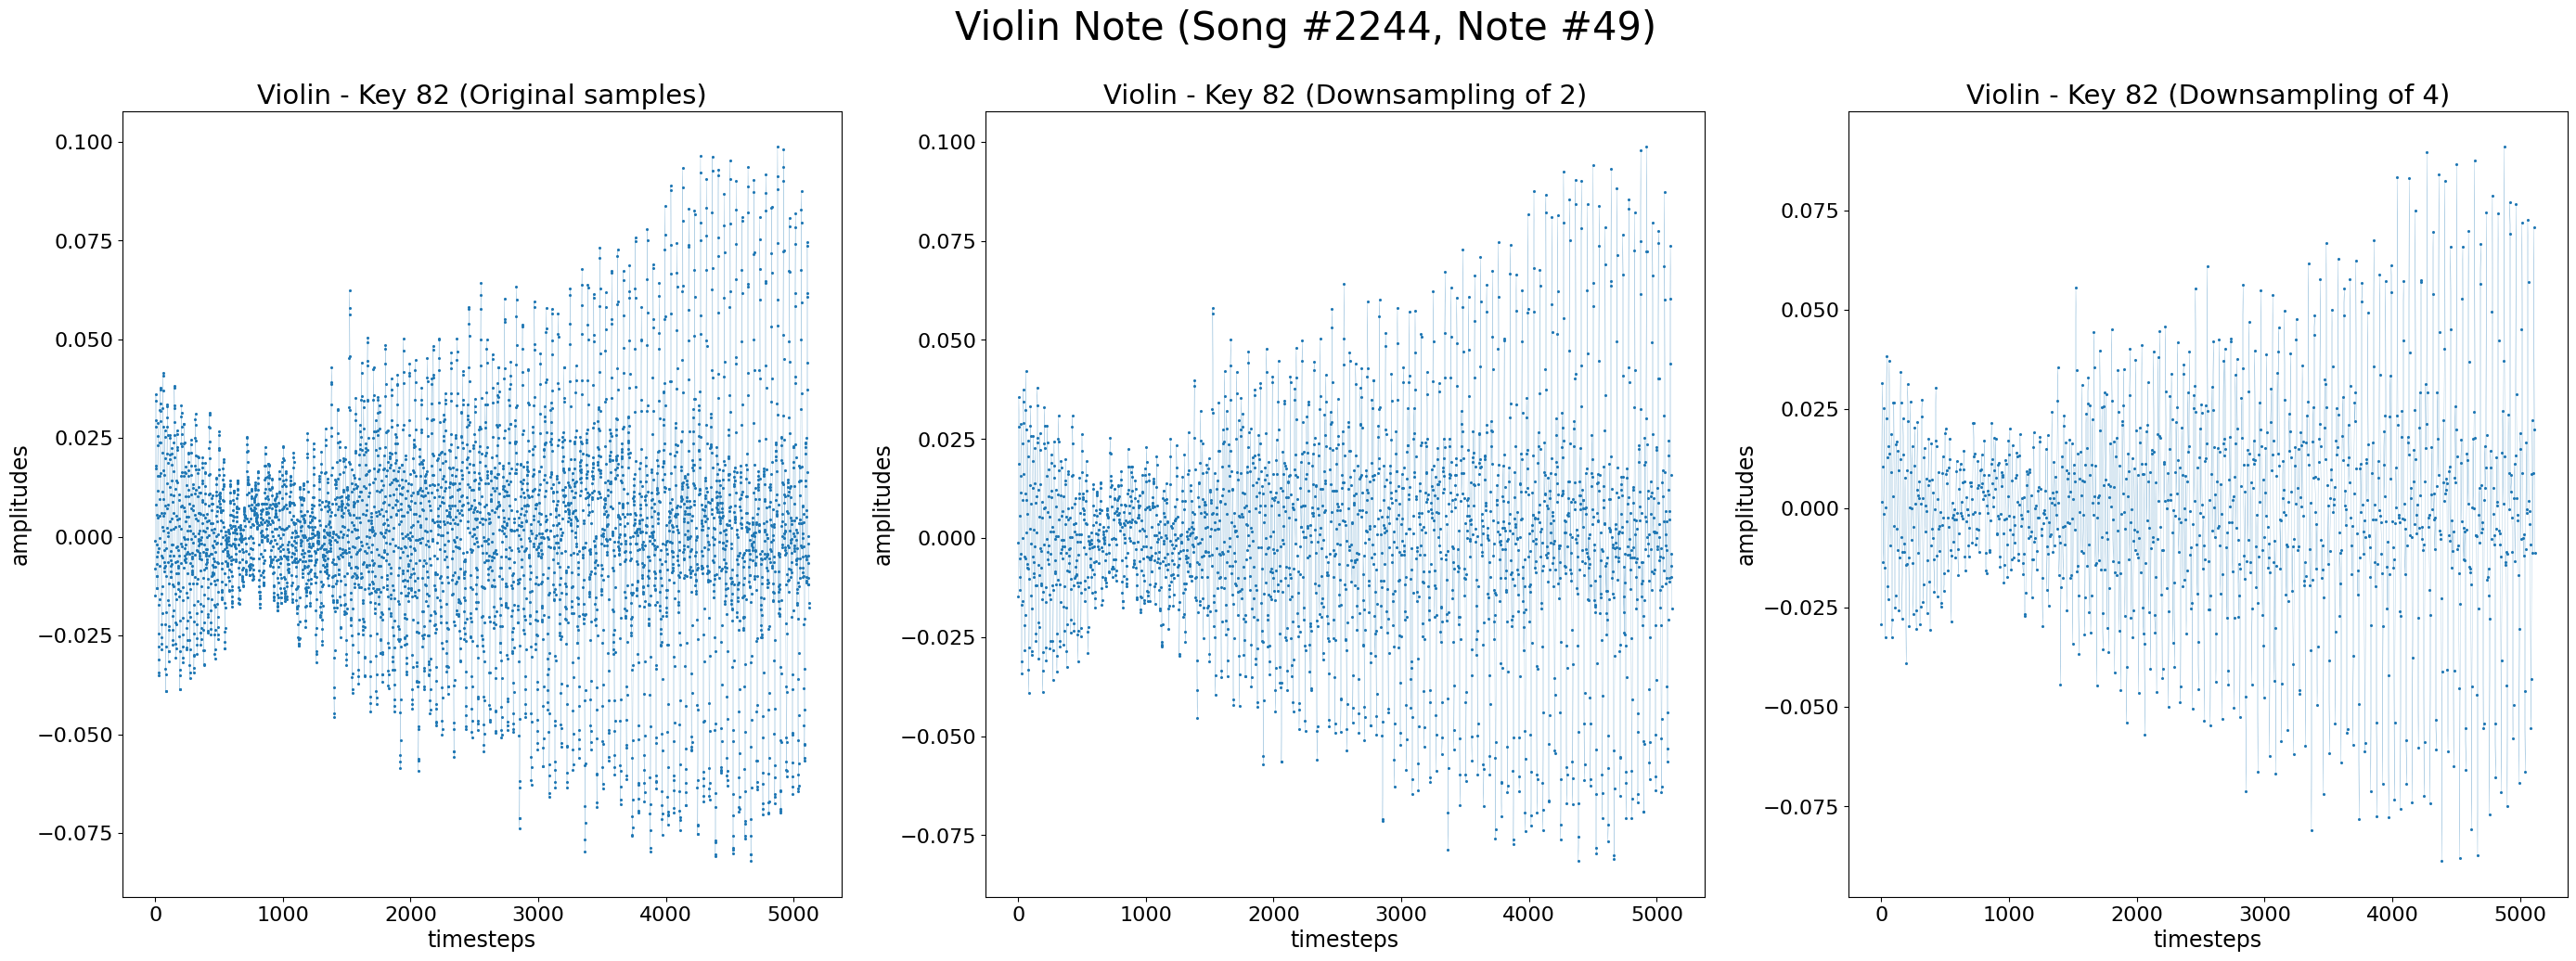

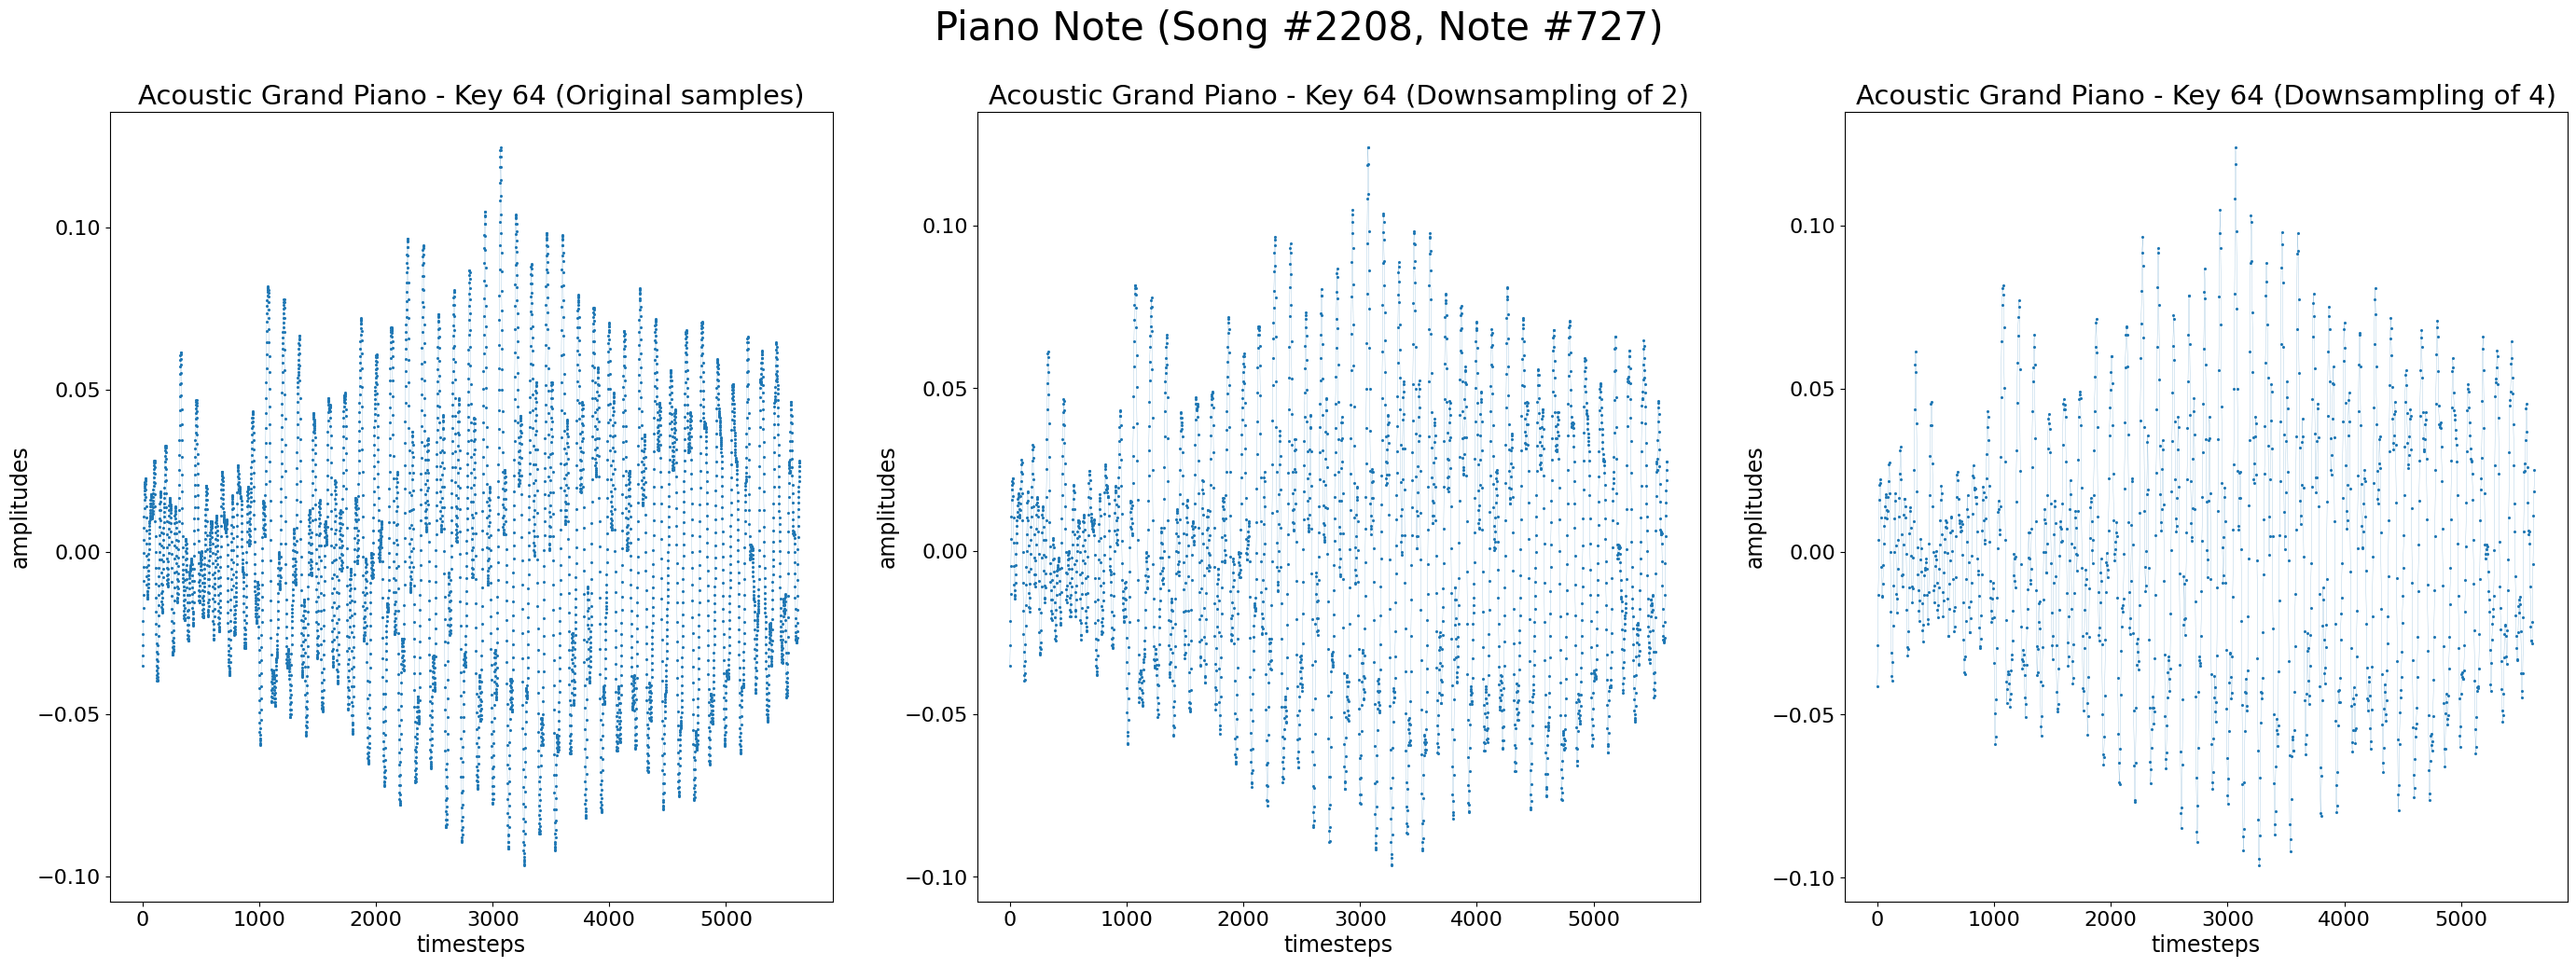

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
base_dir = os.getcwd()
%cd -q $base_dir/core/
from visualize import vis_notes_as_original as vis_notes
%cd -q $base_dir/

# Comparison of downsampling factors
violin_notes_samples = np.load(f"{base_dir}/data/general/violin_note_samples_0-2-4.npy", allow_pickle=True)
violin_notes_labels = np.load(f"{base_dir}/data/general/violin_note_labels_0-2-4.npy", allow_pickle=True)
piano_notes_samples = np.load(f"{base_dir}/data/general/piano_note_samples_0-2-4.npy", allow_pickle=True)
piano_notes_labels = np.load(f"{base_dir}/data/general/piano_note_labels_0-2-4.npy", allow_pickle=True)

title_violin_notes = "Violin Note (Song #2244, Note #49)"
title_piano_notes = "Piano Note (Song #2208, Note #727)"
factors = [None, 2, 4]

print()
vis_notes(violin_notes_samples, violin_notes_labels, factors, title_violin_notes)
print()
vis_notes(piano_notes_samples, piano_notes_labels, factors, title_piano_notes)

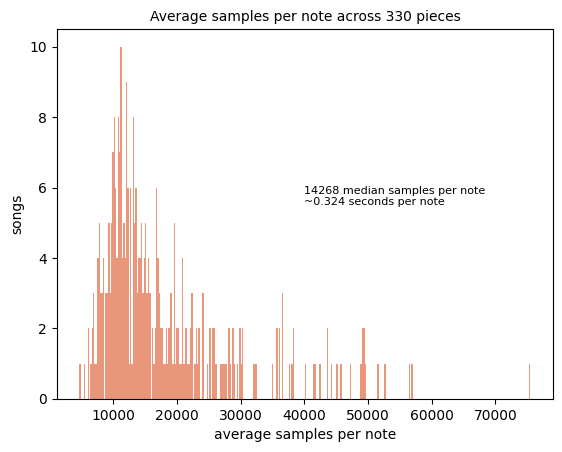

In [4]:
# Comparing average dimensionalities of notes
samples_counts = np.load(f"{base_dir}/data/general/samples_counts.npy")

fig, ax = plt.subplots()
ax.hist(samples_counts, bins=len(samples_counts), color='darksalmon')
ax.set(xlabel='average samples per note', ylabel='songs', title='Average samples per note across 330 pieces')
ax.text(40000, 5.5, f'{np.median(samples_counts):.0f} median samples per note\n'
        f'~{np.median(samples_counts) / 44100:.3f} seconds per note', fontsize=8)
ax.title.set_size(10)
plt.show()

# 4c. Small dataset

*Many deep learning datasets are very large, which is helpful for training powerful models but makes debugging difficult. For your update, you will need to construct a small version of your dataset that contains 200-1000 examples and is less than 10MB. If you are working with images, video, or audio, you may need to downsample your data. If you are working with text, you may need to truncate or otherwise preprocess your data.*

*Give a specific plan for how you will create a small version of one dataset you'll use that is less than 10MB in size. Mention the current size of your dataset and how many examples it has and how those numbers inform your plan.*

> Our entire dataset of 330 song recordings and csv labels is around 20GB in size. Each of the notes-samples objects we construct (containing the timesteps from the songs pertaining to each note that occurs) has averaged to be 3x the size of the songs themselves, most likely because 3 notes co-occur on average at any moment in a song. This means that before dataset reduction or downsampling, constructing our dataset of 330 notes-sample objects equates to 60GB of size.

> The 3 ways we will reduce our dataset size to fit the constraints of this project are:

> 1. We will select a smaller range of songs. The songs that incur the largest constructed notes-samples size are those with many notes co-occuring due to multiple instruments playing. Therefore, we will include primarily solo instrument songs, which both reduce the size of the notes samples for each song and are easier to train with (we explain the overlapping notes challenge below).

> 2. We will train with a set number of notes per song by randomly choosing a number of note indices from the csv labels associated with every piece. Choosing less notes from each song allows us to train on a greater number of songs.

> 3. We will perform downsampling. We have observed that downsampling our song recordings at a rate of 22050 kHz (instead of 44100 kHz) produced a minor loss in the song's cohesive quality. Downsampling further produced a clear loss in cohesive quality. We noticed that on a per-note basis, downsampling's effects are more perceivable; the timesteps of a specific note sound progressively farther from the original as the downsampling factor grows. How downsampling will affect single note generation and applications to longer-range musical structures in the future is not clear. Nonetheless, we will start by downsampling by a factor of 2 (22050 kHz), as it preserves the majority of audio quality and allows us to train with twice as many note samples.

>  However, we would like to note that based on our computations, the samples for each note average to be 0.063 MB (before audio downsampling). This means, to fit a 10 MB dataset limit, we can only train and test on 158 notes. Downsampling by 2 increases this up to 317, and we can consider downsampling more until ~16000 kHz, which is the lower limit common in the literature. We would like to request to be able to train with a larger dataset size. Our dataset itself contains 1 million notes, and we feel it would be helpful to take advantage of training with more than a limited portion of the data. Exposure to more data samples may be necessary to learn the range of pitches (0-88) and instruments that describe how notes sound in the musical domain.

> As mentioned above, one issue we anticipate is audio with layered notes of different instruments. For many of the audio recordings involving quartets or trios, there are moments where notes overlap or even start and end simultaniously, for which it may be more difficult for our model to learn the correct note from the audio. However, with such a large dataset with over 1 million notes (and solo audio recordings in which this is not be an issue), we can certainly filter the data points (notes), which are isolated in the recordings. Thus, this is one way we could find a more managable sized dataset, and have a reduced project scope for our update.

## 5. Methods

*Describe what methods you plan to use. This is a deep learning class, so you should use deep learning methods. Cite at least one or two relevant papers. What model architectures or pretrained models will you use? What loss function(s) will you use and why? How will you evaluate or visualize your model's performance?*

> As we are planning to process all samples for single notes during each pass, we will primarily employ non-autoregressive architectures. The first approach we will explore is a single or two-level VQ-VAE. Following the autoencoder structure of (Dhariwal et al., 2020), we will apply dilated 1-D convolutions and residual connections in our encoder and mirrored 1-D transposed convolutions and residual connections in the decoder. We also plan to experiment with interweaving self-attention layers and bidirectional convolutions in our network as we optimize between learning long range dependencies and minimizing computational costs. For our bottleneck, we will follow the standard VQ-VAE architecture by mapping our raw encodings to codebook vectors while learning the codebook. We will train our model by minimizing the mean squared error reconstruction loss between the input and decoded samples, by pushing our codebook vectors to our raw encoding vectors either with mean squared error or exponential moving average, and by pushing our raw encoding vectors toward our codebook vectors with mean squared error. As (Dhariwal et al., 2020) trained to generate songs from samples&mdash;instead of individual notes from samples&mdash;and employed an autoregressive approach, they trained sparse transformers over the priors for each level of their VQ-VAE. Due to not needing to predict future items in a sequence as we are processing notes in their entirety, we are not following this approach. Training an autoregressive transformer over codebook indices to produce encodings would normally improve the quality of generated audio, but due to time constraints of our project, we will instead try to estimate the prior distribution from the encodings we construct and store during training. We will attempt to promote a Gaussian and disentangled encoding space by careful codebook initialization and network regularization, so that sampling from our encoding distribution can produce good quality samples.

> The other approach we may explore is a diffusion-based audio synthesis model similar to (Kong et al. 2021)'s DiffWave. We would follow their approach of aranging blocks of stacked residual layers, each containing bidirectional convolutional kernels to capture information from earlier and later samples, fully connected layers to embed the denoising timestep and conditioning information, and 1-D convolution layers after the input and before the output. We would train our model to maximize the likelihood of obtaining each note's samples from the true data distribution by progressively adding noise to vectors of the same dimensionality sampled from an isotropic Gaussian distribution. As this likelihood is inextractable, we would be maximizing the variational lower bound, or, following the authors' approach, minimizing an unweighted variant through gradient descent. The benefits of this approach is that it would not require an explicit encoder, and we could condition on a wider range of note compression levels, or potentially the labels themselves containing the instrument, pitch, and length as categorical variables. This would be beneficial should the encoding space of the VQ-VAE be difficult to traverse and decode quality audio from. There are also no additional loss terms or the issues that arise from having to coordinate multiple structural components, such as codebook collapse. The drawback is that the diffusion model requires the equal dimensional inputs, yet the number of input samples vary across all of our notes, which would require us resample all notes or add padding. This could incur training complications and uneven effects on generative quality.

> Besides the loss functions, we will evaluate our model's performance based on the generative quality and variability. For instance, sampling and decoding points from the VQ-VAE's encoding space that are close to seen encodings should yield similar sounding notes, just as decoding the vector average of multiple seen encodings should yield audio that shares qualities from each. Likewise, generating notes with a diffusion model conditioned on labels seen during training should yield similar, yet also novel sounding notes. We can also visualize the samples for the generated notes against the origianl samples for notes in our dataset using our visualization functions.

## 6. Deliverables

*Include at least six goals that you would like to focus on over the course of the quarter. These should be nontrivial, but you should have at least one and hopefully both of your "Essential" goals done by the project update, due in mid-May. Your "Stretch" goals should be ambitious enough such that completing one is doable, but completing both this quarter is unlikely.*

### 6.1 Essential Goals
- (At least two goals here. At least one should involve getting a neural network model running.)

> 1. Get a VQ-VAE model running (modeling after Dhariwal et al. 2020 and Engel et al. 2017) that encodes samples of notes and decodes them into audio sounding similar to the original. We will evaluate this with reconstruction loss. To achieve low reconstruction loss, we will adjust hyperparameters that influence the model complexity: the dilation rate of convolutional layers, the codebook size, the latent dimensionality, the number of residual blocks (convolution + residual -> batch normalization), as well as the complexity of each layer (filter sizes, channels, etc.) By increasing the model complexity with more convolutional filters and latent capacity, we would grant the model a higher learning ceiling with which to reconstruct the data. However, these would need to be balanced with well-adjusted residual connections and batch normalization to prevent memorization and to ensure the learning of a useful latent space. Adjustments like dilation and stride are also important for balancing between learning longer temporal relationships and factoring in local information across note samples. <br>
> 2. To be able to sample and decode from the estimated prior distribution to generate novel audio that sound like notes from the dataset. The essential requirement is to avoid generations becoming complete noise but to share qualities of the training distribution, which we will evaluate through perceptual comparisons and our visualization functions. This rests on our setup of the discretization architecture and latent representation. We focus more on latent traversability and its requirements in the desired section.  <br> <br>
Two codebases we will base our implementation off: https://github.com/ASzot/vq-vae-audio and https://github.com/NoaCahan/WavenetAutoEncoder. The first is based on the VQ-VAE implementation described by the original VQ-VAE paper, adapted for audio using 1-D convolutional filters. We will use apply this in building the discretization and codebook architecture. The second is a WaveNet autoencoder for synthesizing musical notes. We will refer to this for constructing our encoder and decoder. Note: the source paper, "Neural Audio Synthesis for Musical Notes with WaveNet Autoencoders," also contains its own musical note database (https://magenta.tensorflow.org/datasets/nsynth), which we may consider using in conjunction with our classical music database.



### 6.2 Desired Goals
- (At least two goals here. Completing these goals should be sufficient for you to say your project was a success.)


> 1. To achieve a smooth latent distribution with regards to instrument type. This means that beyond decodings sounding listenable, there is control over traversing across the encoding space with regards to producing the audible distinctions that distinguish instruments in the dataset. This also entails that sampling between the encoding spaces of non-identical instruments produces novel notes sharing perceptible qualities of nearby instruments.
> 2. To enable a traversability over more complex musical qualities like pitch and intensity. As the number of pitches far exceed the number of instruments, as well as the fact that the sounds of two pitches are harder to differentiate than the sounds of two instruments, this is harder to learn. We aim to observe that traversing across the encoding space associated with a given instrument can 1) sound like the instrument and 2) offer a degree of transition among pitches and intensities. <br>

> While VAEs achieve these objectives by deliberately enforcing a smooth, Gaussian latent space, VQ-VAEs impose a finite limit on embeddings, which forces our model to learn a compact representation of notes that ideally yields us a semantic and abstracted sampling space. These goals come down to tweaking the discretization architecture: latent dimensionality and magnitude, codebook size, and codebook coverage (invoking codebook resets or normalizing encoding outputs to be larger than codebook mappings). We aim for hyperparameters that constrain the model to learn a useful embedding space with semantic traversability but also grant it the learning capacity to produce listenable audio.

> The motivation for these goals is to provide a tool for musicians and producers to explore new musical ideas and variations on existing ones, by generating new notes that are similar to existing ones in the dataset but with variations that make them unique. Currently, virtual studio instruments (VSTs) often come at a cost, and may not reflect the individual style of a musician or producer. Our model offers a solution to this problem. For example, one could theoretically train on note recordings of Jimi Hendrix's playing guitar and it would generate audio based on his specific style and instrument sound. While capturing style with individual notes may be challenging, we believe that this feature would still be useful as this is an existing problem with VSTs.


### 6.3 Stretch Goals
- (At least two goals here. These should be ambitious extensions to your desired goals. You can still get full points without completing these.)
    
> 1. A stretch goal of the project is to demonstrate the potential for the encoding scheme to serve as a more effective and interpretable method for storing and transmitting musical pieces. By compressing raw audio recordings into lower-dimensional encodings, the resulting data can be stored and transmitted with significantly reduced file sizes compared to the original audio recordings. Further, having reference to the notes that make up a piece can offer an abundance of applications. <br>

> - Method: Longer range modeling (multi-note or songs) can be approached by expanding our VQ-VAE in an autoregressive setting where it is trained to identify the occurences of notes throughout a song, extract samples for the notes it sees, and encode them into its hidden state. The model would employ multiple receptive fields, through which windows of samples from the song are slid over and fed in one at a time. Each receptive field would follow the structure of the VQ-VAE's encoder, enabling the encoding of raw samples into a hidden state where associations with learned note embeddings can be made. The primary difference is that now the encodings must account for notes' relative times of occurence. At some decided point, it would begin decoding the accumulated hidden state script of note encodings back into the original song, applying upsampling channels with the structure of the VQ-VAE decoder, from which the reconstruction loss is optimized. This many-to-many autoregressive architecture would enable the compression of songs into a list of note encodings. At transmission time, a script of compressed note encoding hidden states can be decoded back into the original song. The smallest-scale approach to this method involves training on sequences of samples over a short span of time&mdash;not nearly as long as a song, but covering more than a single note.
    
> - Motivation: Song compression and transmission has applications in fields such as music streaming, audio processing, and data compression. Training on music represented by note encodings instead of raw audio can also prove to be much more effective as the dimensionality is much lower. Another use case is Real-Time Sheet Music Transcription: by changing the decoding domain from original audio to music notation, one could apply the system in a streamable setting to transcribe live audio performances into sheet music in real-time. This could revolutionize music education by allowing learners to visually see and learn the notes being played, and make it easier for musicians to document their own compositions. Additionally, the system could be used to generate sheet music from pre-existing audio recordings, providing a new way to transcribe and analyze music. While this is a challenging goal, we believe that it has the potential to be a game-changer in the world of digital music production.

> 2. The other stretch objective is to evalute the VQ-VAE's generative potential in producing longer-range musical structures. The simplest approach is to investigate whether single note decodings arranged in the order of their appearance sound like an original melody or bar from the song. As the model was not trained to ensure congruence across notes, it would be interesting to see how its capability of learning the latent distribution for single notes applies when decodings are strung together. However, the more valuable approach involves implementing the model in a multi-note learning setting either by 1) expanding the VQ-VAE to encode and decode audio over a temporal window containing more than a single note, or 2) implementing the VQ-VAE in an autoregressive setting.
    
> - Method: We can apply the same VQ-VAE architecture but expand the input window and model complexity to encode and decode recordings containing multiple notes. We can alternatively employ the autoregressive methodology described in the first stretch goal. Ideally, as the autoregressive song VQ-VAE is trained to read notes from songs, encode them, and reconstruct the original songs, it will learn the probability distribution over sequences of tokenized note-time encodings. Learning the likelihood of token sequences over the dataset, where each token corresponds to a note encoding tied with its occurence time, would enable the model to generate melodies or short pieces, in either an one-to-many or many-to-many setting.
    
> - Motivation: Learning to recognize and generate tracks played by different instruments over audio recordings is difficult. By learning the relationships among different notes played by distinct instruments, a model would inherently learn source separation techniques that can improve upon existing tools, such as blind source separation (BSS) or independent component analysis (ICA), to distinguish between audio signals from different instruments in a recording. Leveraging the relationships among interplaying instruments and note sequence distributions, the model can generate new tracks that combine different instruments in unique and interesting ways, ultimately enhancing the creative possibilities of music production.

## 7. Hopes and Concerns

*What are you most excited about with this project? What parts, if any, are you nervous about? For example:*

> Hopes:

> Successfully train a generative model on audio samples to learn the function representative of a note.

> Build a traversable encoding space we can sample from and decode to generate audio for novel notes.

> Explore a variety of autoencoding and generative architectures - transformer, convolutional, diffusion, and VQ-VAE models.

> Minimize the reconstruction loss between inputs and decodings and maximize the likelihood of seeing the generated notes.

> Use a lower-dimensional representation of audio data to learn songs at the granular level of individual notes and thus make training models on musical songs easier.

> Seeing how the generated notes samples turn out when plotted against the notes in our data <br><br>

> Concerns:

> Whether what our model churns out is listenable or not

> Whether different input sizes (number of samples) will be an issue

> Compressing audio recordings of single notes from classical music pieces is a challenging task because of the many samples involved at each second.

> Downsampling may be ineffective since humans perceive frequencies up to 20 kHz, so downsampling may make notes sound worse

> Training generative models on music is computationally expensive and requires significant resources.

> Whether the audio for one note is too short to learn anything interesting

> Whether audio of overlapping notes prevents our model from learning anything

## 8. References

*Cite the papers or sources that you used to discover your datasets and/or models, if you didn't include the citation above.*

> Engel, Jesse, et al. ‘Neural Audio Synthesis of Musical Notes with WaveNet Autoencoders’. ArXiv [Cs.LG], 2017, http://arxiv.org/abs/1704.01279. arXiv.

> Dhariwal, Prafulla, et al. ‘Jukebox: A Generative Model for Music’. ArXiv [Eess.AS], 2020, http://arxiv.org/abs/2005.00341. arXiv. 

> Kong, Zhifeng, et al. ‘DiffWave: A Versatile Diffusion Model for Audio Synthesis’. ArXiv [Eess.AS], 2021, http://arxiv.org/abs/2009.09761. arXiv.